Arquivo 'perfil_dose_X.txt' salvo com sucesso.
Arquivo 'pdp.txt' salvo com sucesso.


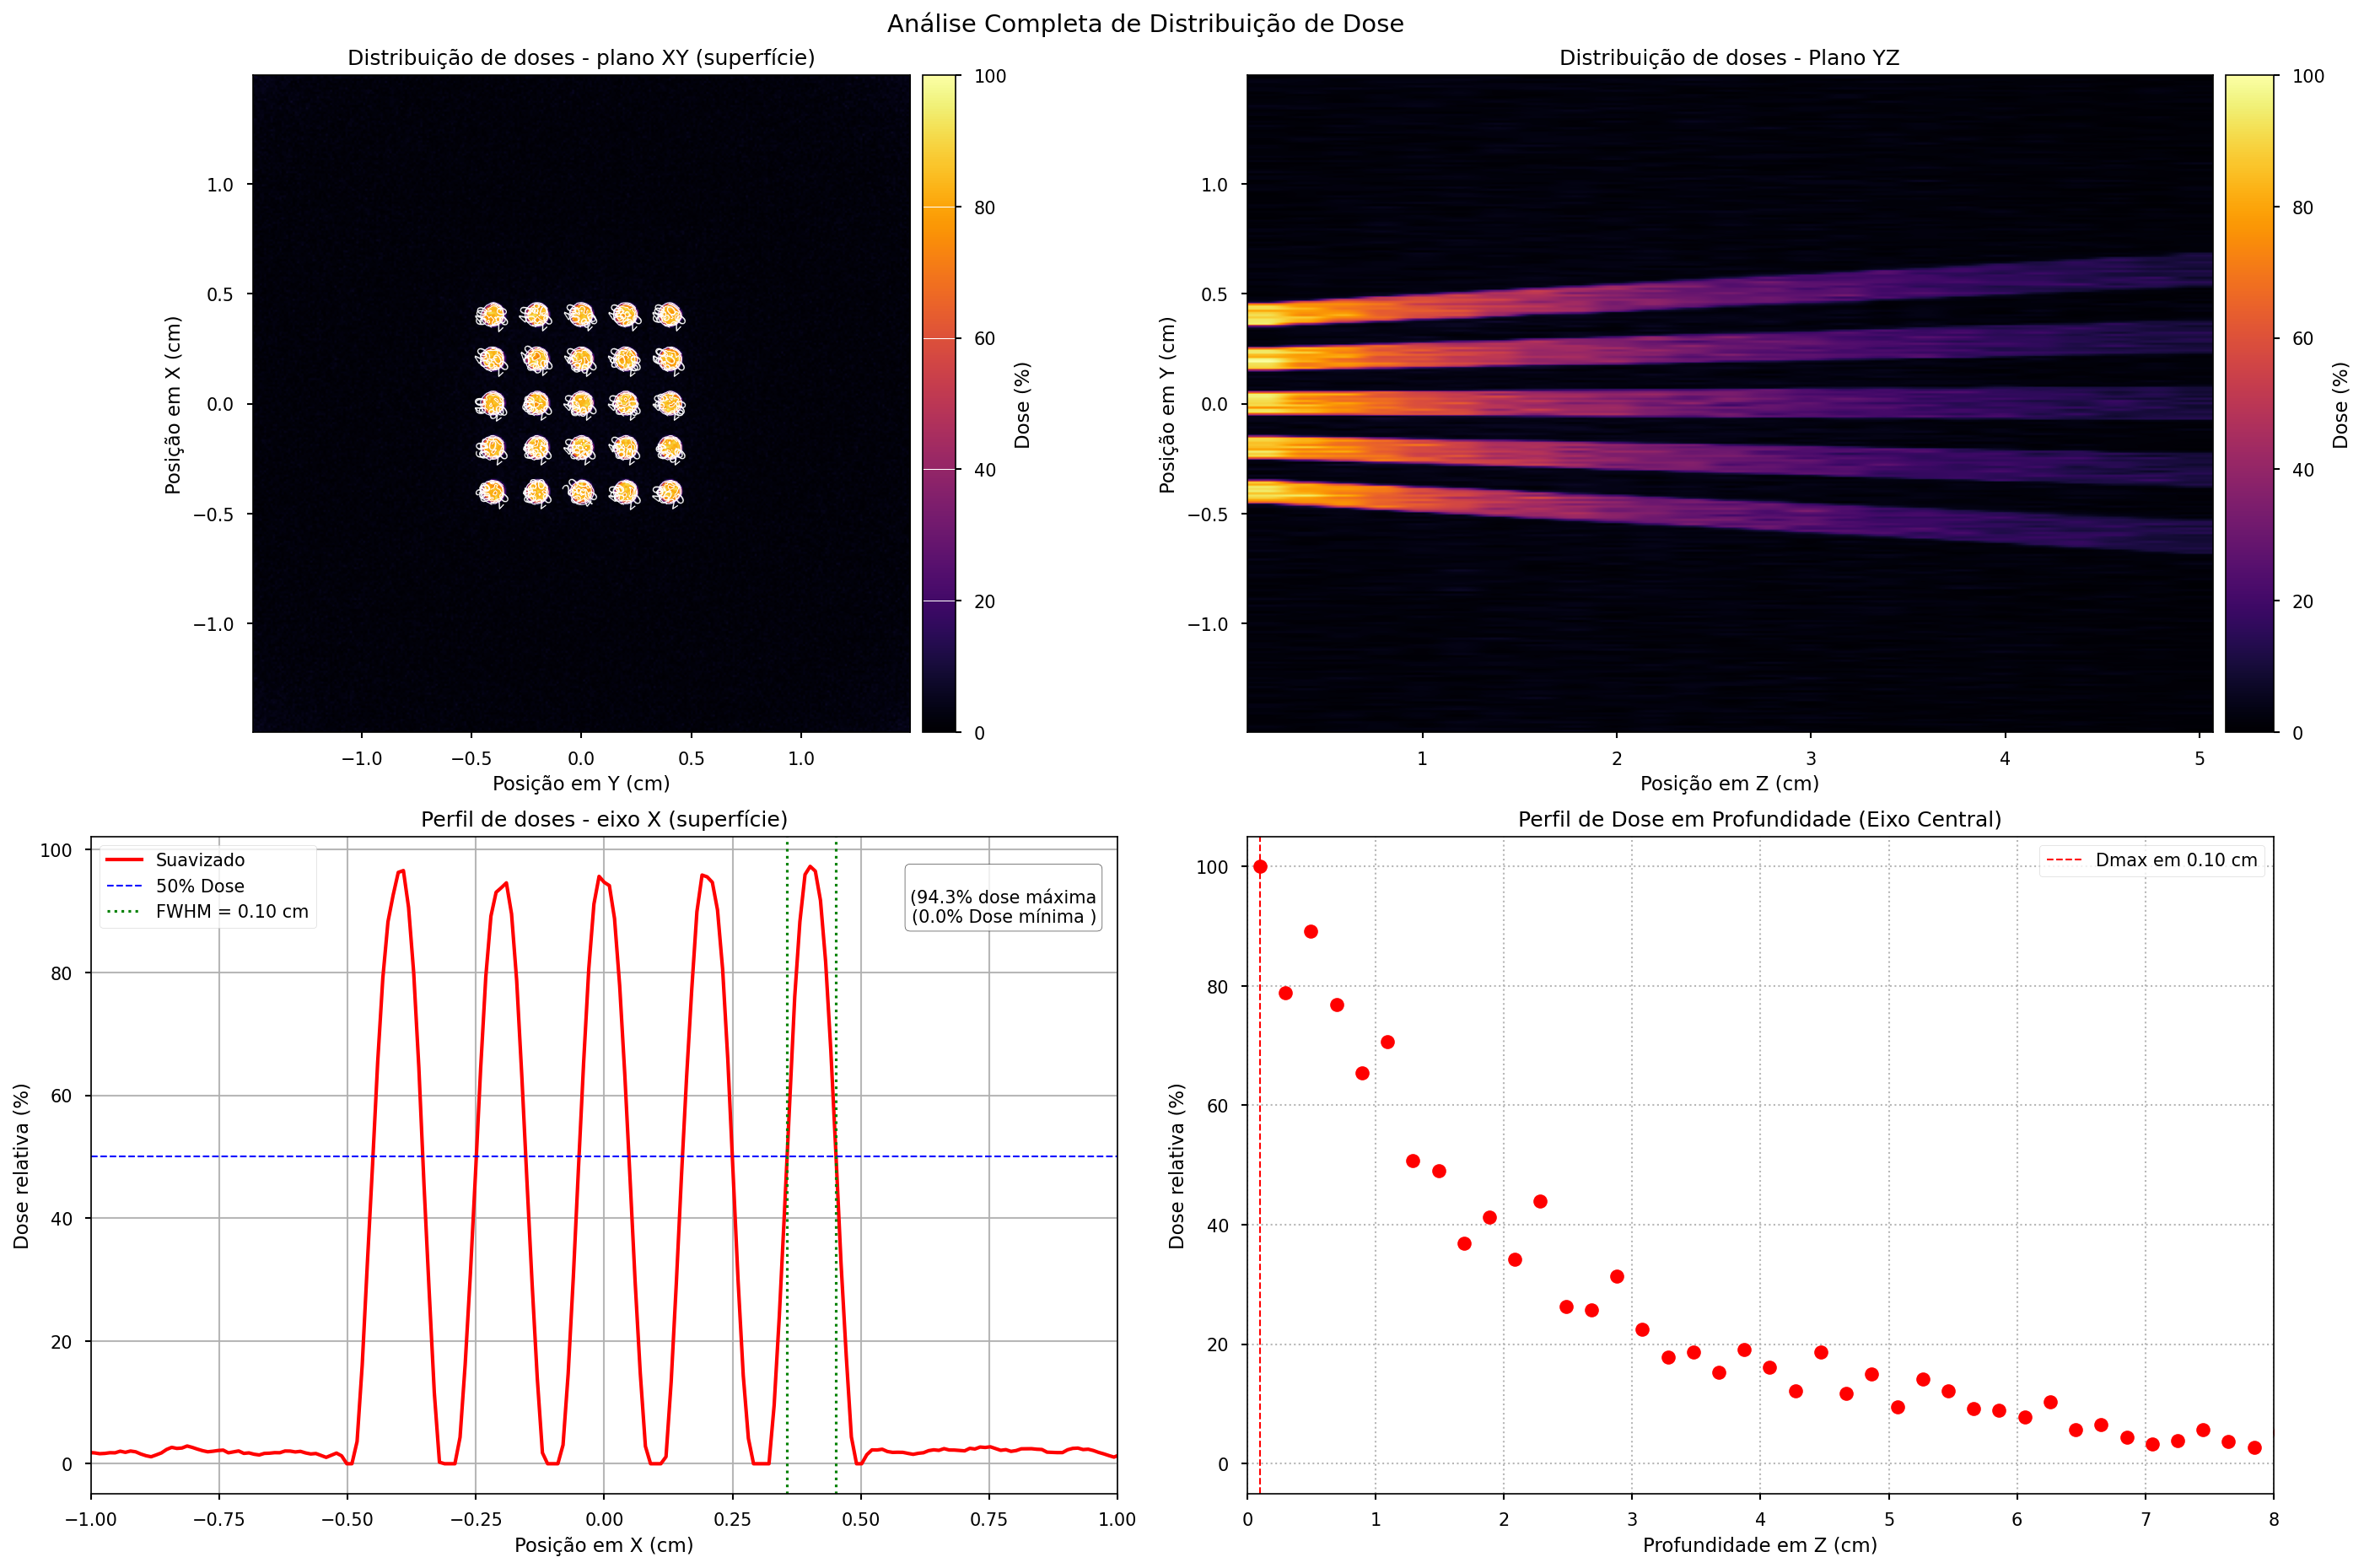

Menor dose: 0.00% na posição X = -0.50 cm


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
arquivo = 'C:\\penelope\\KERNEL\\Latao 25 furos\\3d-dose.dat'
Arq = np.loadtxt(arquivo)  # Carregar o arquivo

# Obtém o número de linhas e colunas do arquivo
linhas, colunas = Arq.shape

# Inicializar as matrizes de Dose e ErrDose com base nos índices máximos encontrados
i_max = int(np.max(Arq[:, 5]))
j_max = int(np.max(Arq[:, 6]))
k_max = int(np.max(Arq[:, 7]))
Dose = np.zeros((i_max, j_max, k_max))
ErrDose = np.zeros((i_max, j_max, k_max))
MaxDose=np.max(Dose)

# Montar as matrizes de Dose e ErrDose
for n in range(linhas):
    i = int(Arq[n, 5]) - 1  # Ajustando para índice zero
    j = int(Arq[n, 6]) - 1  # Ajustando para índice zero
    k = int(Arq[n, 7]) - 1  # Ajustando para índice zero
    Dose[i, j, k] = Arq[n, 3]
    ErrDose[i, j, k] = Arq[n, 4]
    
    if Dose[i, j, k] > MaxDose:
        MaxDose = Dose[i, j, k]
        MaxErrDoseMax = 100 * ErrDose[i, j, k] / Dose[i, j, k]
        MaxDoseVoxel = [i + 1, j + 1, k + 1]  # Converte de volta para índice 1

# Calcula o Grid3dDose e VoxelSize
Grid3dDose = [Arq[-1, 0] - Arq[0, 0], Arq[-1, 1] - Arq[0, 1], Arq[-1, 2] - Arq[0, 2]]
VoxelSize = [Grid3dDose[0] / (i_max - 1), Grid3dDose[1] / (j_max - 1), Grid3dDose[2] / (k_max - 1)]
Grid3dDose = [i_max * VoxelSize[0], j_max * VoxelSize[1], k_max * VoxelSize[2]]

# Posições dos centros dos voxels
VoxelsX = (np.arange(1, i_max + 1) * VoxelSize[0]) - (VoxelSize[0] / 2)
VoxelsY = (np.arange(1, j_max + 1) * VoxelSize[1]) - (VoxelSize[1] / 2)
VoxelsZ = (np.arange(1, k_max + 1) * VoxelSize[2]) - (VoxelSize[2] / 2)

# Corrigir as escalas para o centro do campo
EscalaX = np.linspace(-Grid3dDose[0]/2 + VoxelSize[0]/2, Grid3dDose[0]/2 - VoxelSize[0]/2, i_max)
EscalaY = np.linspace(-Grid3dDose[1]/2 + VoxelSize[1]/2, Grid3dDose[1]/2 - VoxelSize[1]/2, j_max)
EscalaZ = VoxelsZ
# Configurações gerais
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 150
cmap = 'inferno'

def plot_dose_consolidado(Dose, EscalaX, EscalaY, EscalaZ, MaxDose, i_max, j_max):
    """Plota todos os gráficos em uma única figura com colorbars individuais."""
    
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    
    # Título principal
    fig.suptitle(f'Análise Completa de Distribuição de Dose\n', 
                fontsize=14, y=1.02)
    
    # 1. Plano XY (superfície)
    ax1 = fig.add_subplot(gs[0, 0])
    PlanoXY = np.squeeze(100 * Dose[:, :, 0])
    max_dose_local_XY = np.max(PlanoXY)
    PlanoXY = 100 * PlanoXY/ max_dose_local_XY
    im1 = ax1.imshow(
        PlanoXY, 
        extent=[EscalaY[0], EscalaY[-1], EscalaX[0], EscalaX[-1]], 
        origin='lower', 
        cmap=cmap,
        vmin=0, 
        vmax=100
    )
    ax1.set_title('Distribuição de doses - plano XY (superfície)')
    ax1.set_xlabel('Posição em Y (cm)')
    ax1.set_ylabel('Posição em X (cm)')
    
     #Adiciona contornos
    levels = [20, 40, 60, 80]
    CS = ax1.contour(
       EscalaY, EscalaX, PlanoXY, 
    levels=levels, colors='white', linewidths=0.5
    )
    ax1.clabel(CS, inline=True, fontsize=8)
    
    # Colorbar para Plano XY
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('Dose (%)')
    cbar1.add_lines(CS)
    
    # 2. Plano YZ (corte central)
    ax2 = fig.add_subplot(gs[0, 1])
    PlanoYZ = np.squeeze(100 * Dose[int(i_max/2), :, :25])
    max_dose_local_YZ= np.max(PlanoYZ)
    PlanoYZ = 100 * PlanoYZ / max_dose_local_YZ
    extent_z_cut = [EscalaZ[0], EscalaZ[25], EscalaY[0], EscalaY[-1]]
    
    im2 = ax2.imshow(
        PlanoYZ,
        extent=extent_z_cut,
        origin='lower',
        aspect='auto',
        cmap=cmap,
        vmin=0,
        vmax=100
    )
    ax2.set_title('Distribuição de doses - Plano YZ')
    ax2.set_xlabel('Posição em Z (cm)')
    ax2.set_ylabel('Posição em Y (cm)')
    
    # Colorbar para Plano YZ
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.1)
    cbar2 = plt.colorbar(im2, cax=cax2)
    cbar2.set_label('Dose (%)')
    
    # 3. Perfil de dose em X
    ax3 = fig.add_subplot(gs[1, 0])
    Perfil =  Dose[:, int(j_max/2), 0] 
    Max_perfil= np.max(Perfil)
    perfil_norm = 100 * Perfil / Max_perfil  # Perfil normalizado (%)
    

    # ======== FILTRO PARA REDUZIR RUÍDO ======== #
    # Garante que o window_length seja ímpar e menor que o tamanho do perfil
    window_length = min(len(perfil_norm) // 2 * 2 - 1, 11)
    perfil_suavizado = savgol_filter(perfil_norm, window_length=window_length, polyorder=3)
    # Elimina valores negativos
    perfil_suavizado = np.clip(perfil_suavizado, 0, None)

    idx_min = np.argmin(perfil_suavizado)       # índice do menor valor
    idx_max = np.argmax(perfil_suavizado)
    min_dose = perfil_suavizado[idx_min] # valor mínimo (%)
    max_dose_val = perfil_suavizado[idx_max]
    min_pos = EscalaX[idx_min]                  # posição em X correspondente
    max_pos = EscalaX[idx_max]
    # Plot perfil original e suavizado
    #ax3.plot(EscalaX, perfil_norm, color='red', linestyle=':', linewidth=1, label='Original')
    ax3.plot(EscalaX, perfil_suavizado, 'r-', linewidth=2, label='Suavizado')
    ax3.set_title('Perfil de doses - eixo X (superfície)')
    ax3.set_xlabel('Posição em X (cm)')
    ax3.set_ylabel('Dose relativa (%)')
    ax3.grid(True, linestyle=':', alpha=0.9)
    ax3.set_xlim(-1, 1)
    # Usar o perfil suavizado para o cálculo do FWHM
    perfil_para_fwhm = perfil_suavizado
    dados_perfil = np.column_stack((EscalaX, perfil_suavizado))
    np.savetxt("perfil_dose_X.txt", dados_perfil, fmt="%.6f", delimiter="\t",header="Posicao_X_cm\tDose_relativa_%",  # cabeçalho
    comments="")
    print("Arquivo 'perfil_dose_X.txt' salvo com sucesso.")
    # ===== NOVO TRECHO ADICIONADO ===== #
    idx_peak = np.argmax(perfil_para_fwhm)
    n = len(perfil_para_fwhm)
    x_left, x_right = None, None

    # Busca pelo cruzamento à esquerda
    for i in range(idx_peak, 0, -1):
        if perfil_para_fwhm[i-1] < 50 <= perfil_para_fwhm[i]:
            x0, x1 = EscalaX[i-1], EscalaX[i]
            y0, y1 = perfil_para_fwhm[i-1], perfil_para_fwhm[i]
            x_left = x0 + (x1 - x0) * (50 - y0) / (y1 - y0)
            break

    # Busca pelo cruzamento à direita
    for i in range(idx_peak, n-1):
        if perfil_para_fwhm[i] >= 50 and perfil_para_fwhm[i+1] < 50:
            x0, x1 = EscalaX[i], EscalaX[i+1]
            y0, y1 = perfil_para_fwhm[i], perfil_para_fwhm[i+1]
            x_right = x0 + (x1 - x0) * (50 - y0) / (y1 - y0)
            break

    # Desenhar elementos gráficos se encontrado FWHM
    if x_left is not None and x_right is not None:
        FWHM = x_right - x_left
        # Linha de 50%
        ax3.axhline(50, color='b', linestyle='--', linewidth=1, label='50% Dose')
        # Marcadores FWHM
        ax3.axvline(x_left, color='g', linestyle=':', linewidth=1.5)
        ax3.axvline(x_right, color='g', linestyle=':', linewidth=1.5, 
                   label=f'FWHM = {FWHM:.2f} cm')
    
    # Caixa de informações
    info_text = f'\n({100*Max_perfil/MaxDose:.1f}% dose máxima' f'\n({min_dose:.1f}% Dose mínima )'
    ax3.text(0.98, 0.95, info_text, 
            transform=ax3.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    ax3.grid(True, linestyle='-', alpha=0.9)
    # Atualizar legenda
    ax3.legend(loc='upper left')

    
    # 4. PDP (eixo central)
    ax4 = fig.add_subplot(gs[1, 1])
    DoseZ = np.squeeze(Dose[int(i_max/2), int(j_max/2), :])
    MaxDoseZ = np.max(DoseZ)
    pdp_norm = 100 * DoseZ / MaxDoseZ
    # Salvar dados da PDP (perfil de dose em profundidade) em arquivo TXT
    dados_pdp = np.column_stack((EscalaZ, pdp_norm))
    np.savetxt("pdp.txt", dados_pdp, fmt="%.6f", delimiter="\t", header="Profundidade_Z_cm\tDose_relativa_%",
    comments="")
    print("Arquivo 'pdp.txt' salvo com sucesso.")

    ax4.plot(EscalaZ, 100 * DoseZ / MaxDoseZ, 'ro', markersize=8)
    ax4.set_title('Perfil de Dose em Profundidade (Eixo Central)')
    ax4.set_xlabel('Profundidade em Z (cm)')
    ax4.set_ylabel('Dose relativa (%)')
    ax4.grid(True, linestyle=':', alpha=0.9)
    ax4.set_xlim(0, 8)
    # Marca Dmax
    z_max = EscalaZ[np.argmax(DoseZ)]
    ax4.axvline(x=z_max, color='r', linestyle='--', linewidth=1, 
               label=f'Dmax em {z_max:.2f} cm')
    ax4.legend()
    
    plt.show()


    # Exibir no console
    print(f"Menor dose: {min_dose:.2f}% na posição X = {min_pos:.2f} cm")

# Chamada da função
plot_dose_consolidado(Dose, EscalaX, EscalaY, EscalaZ, MaxDose, i_max, j_max)


In [3]:
import numpy as np

# Carregar os dados do arquivo .dat
arquivo = 'C:\\penelope\\KERNEL\\kernel resolucao 0.5\\3d-dose1.dat'
dados = np.loadtxt(arquivo)

# Encontrar o voxel com MAIOR ERRO (coluna 5, índice 4)
indice_max_erro = np.argmax(dados[:, 4])  # Índice da linha com maior erro (3σ)
voxel_max_erro = {
    'coordenadas': dados[indice_max_erro, 0:3],  # X, Y, Z (cm)
    'dose': dados[indice_max_erro, 3],           # Dose (eV/g)
    'erro_3sigma': dados[indice_max_erro, 4],    # Erro estatístico (3σ)
    'indices': dados[indice_max_erro, 5:8]       # IX, IY, IZ (índices do voxel)
}

print("Voxel com maior erro estatístico (3σ):")
print(f"- Coordenadas (X, Y, Z): {voxel_max_erro['coordenadas']} cm")
print(f"- Dose: {voxel_max_erro['dose']} eV/g")
print(f"- Erro (3σ): {voxel_max_erro['erro_3sigma']}")
print(f"- Índices do voxel (IX, IY, IZ): {voxel_max_erro['indices']}")

# Verificar se o erro está associado a uma dose baixa (opcional)
if voxel_max_erro['dose'] < 1e-6:  # Ajuste o limite conforme necessário
    print("\nAVISO: Este voxel tem dose muito baixa, o que pode explicar o alto erro.")

Voxel com maior erro estatístico (3σ):
- Coordenadas (X, Y, Z): [0.006623 0.03311  0.06623 ] cm
- Dose: 470.911 eV/g
- Erro (3σ): 100.0
- Índices do voxel (IX, IY, IZ): [77. 81.  1.]
